## The Kaggle Rossman Competition

This was a kaggle competition to forecast sales at a pharmacy chain/dept store in Europe. It was run back in 2015.

Rossmann operates over 3,000 drug stores in 7 European countries. As a data analyst for this store, you are tasked with forecasting their daily sales for up to six weeks in advance.

You will need to look at various factors influencing the forecast predictions - the primary ones being promotions, competition, school and state holidays, seasonality, and locality.


While working through this homework, you will:

1. see how to "grid-search" when the data is too large to use cross-validation. This is in opposition to the other way we usually do grid search using pipelines. But we still want to use sklearn/dask pipelines as much as possible so that ALL transformations can be used on validation and test sets
2. understand some aspects of feature engineering that come in with continuous and categorical variables, and see some of the new features in sklearn 0.20
3. capture results from validation
4. investigate the use of categorical "embeddings" to improve performance of a multi-layer percepton


### Preprocessing

In [13]:
import numpy as np
import scipy.stats
import scipy.special

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import cm
import pandas as pd
%matplotlib inline

In [14]:
from pathlib import Path

In [95]:
data = Path('D:/Documents/AI course/LogisticText/data')

We engage in some cleaning. A lot of cleaning of this dataset has already been done for us. Some features have been created. In particular we moved from dates to week-of-year, day-of week, etc. For example the 49th and 50th weeks of the year may have higher sales!

In [21]:
train_df = pd.read_csv(data/"train_clean.csv.gz", compression='gzip').drop(['index', 'PromoInterval'], axis=1)
test_df = pd.read_csv(data/"test_clean.csv.gz", compression='gzip').drop(['index', 'PromoInterval'], axis=1)

In [22]:
train_df['Events'] = train_df['Events'].fillna('None')
test_df['Events'] = test_df['Events'].fillna('None')

We log-transform the dependent variable because it is long-tailed. Plot a histogram of Sales to see this

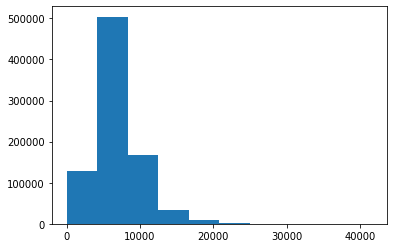

In [24]:
# your code here
plt.hist(train_df['Sales']);

In [25]:
train_resp = np.log(train_df['Sales'].copy())
train_df = train_df.drop('Sales', axis=1)

Lets get some idea about our dataset.

In [26]:
train_df.head()

,Store,DayOfWeek,Date,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw
0,1,5,2015-07-31,555,1,1,False,1,2015,7,...,57,0,0,0,5.0,0.0,5.0,7.0,0.0,5.0
1,2,5,2015-07-31,625,1,1,False,1,2015,7,...,67,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0
2,3,5,2015-07-31,821,1,1,False,1,2015,7,...,57,0,0,0,5.0,0.0,5.0,5.0,0.0,5.0
3,4,5,2015-07-31,1498,1,1,False,1,2015,7,...,67,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0
4,5,5,2015-07-31,559,1,1,False,1,2015,7,...,57,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0


In [27]:
train_df.shape, test_df.shape

((844338, 90), (41088, 90))

In [28]:
train_df.Date # latest date first

0         2015-07-31
1         2015-07-31
2         2015-07-31
3         2015-07-31
4         2015-07-31
             ...    
844333    2013-01-01
844334    2013-01-01
844335    2013-01-01
844336    2013-01-01
844337    2013-01-01
Name: Date, Length: 844338, dtype: object

In [29]:
train_df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Week', 'Day',
       'Dayofweek', 'Dayofyear', 'Is_month_end', 'Is_month_start',
       'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start',
       'Elapsed', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'State', 'file', 'week', 'trend',
       'file_DE', 'week_DE', 'trend_DE', 'Date_DE', 'State_DE', 'Month_DE',
       'Day_DE', 'Dayofweek_DE', 'Dayofyear_DE', 'Is_month_end_DE',
       'Is_month_start_DE', 'Is_quarter_end_DE', 'Is_quarter_start_DE',
       'Is_year_end_DE', 'Is_year_start_DE', 'Elapsed_DE', 'Max_TemperatureC',
       'Mean_TemperatureC', 'Min_TemperatureC', 'Dew_PointC', 'MeanDew_PointC',
       'Min_DewpointC', 'Max_Humidity', 'Mean_Humidity', 'Min_Humidity',
       'Max_Sea_Level_PressurehPa', 'Mean_Sea_Le

### Types of variables and cardinality

We make a note of which variables are categorical and which are not. This is a choice. If cardinality is not too high, binning or categorizing can be beneficial. Often this will be true for integer valued variables.

In [30]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw', 'Promo', 'SchoolHoliday']

cont_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday']

We look for missing data and store the column names where this happend in the continuous data

In [32]:
nacols=[]
for v in cont_vars:
    if np.sum(train_df[v].isnull()) > 0:
        nacols.append(v)
        print(v, np.sum(train_df[v].isnull()))

CompetitionDistance 2186
CloudCover 68056


And look at some cardinalities (unique values) of the continuous data: if we have none below 10, we won't engage in binning.

In [34]:
# your code here
for k in cont_vars:
    print(k, train_df[k].unique().shape[0])
    if train_df[k].unique().shape[0] < 10:
        print(train_df[k].unique())

CompetitionDistance 655
Max_TemperatureC 50
Mean_TemperatureC 45
Min_TemperatureC 40
Max_Humidity 50
Mean_Humidity 71
Min_Humidity 93
Max_Wind_SpeedKm_h 42
Mean_Wind_SpeedKm_h 27
CloudCover 10
trend 67
trend_DE 38
AfterStateHoliday 136
BeforeStateHoliday 147


We do a similar looksie on the categorical variables. Some of these have many levels. Is there really that much information in 1115 store labels. Can we get some compression to increase our signal-to-noise?

In [35]:
# your code here
for k in cat_vars:
    print(k, train_df[k].unique().shape[0])
    if train_df[k].unique().shape[0] < 50:
        print(train_df[k].unique())

Store 1115
DayOfWeek 7
[5 4 3 2 1 7 6]
Year 3
[2015 2014 2013]
Month 12
[ 7  6  5  4  3  2  1 12 11 10  9  8]
Day 31
[31 30 29 28 27 26 25 24 23 22 21 20 19 18 17 16 15 14 13 12 11 10  9  8
  7  6  5  4  3  2  1]
StateHoliday 2
[False  True]
CompetitionMonthsOpen 25
[24  3 19  9  0 16 17  7 15 22 11 13  2 23 12  4 10  1 14 20  8 18  6 21
  5]
Promo2Weeks 26
[ 0 25 17  8 13 24 16  7 12 23 15  6 11 22 14  5 10 21  4  9 20  3 19  2
 18  1]
StoreType 4
['c' 'a' 'd' 'b']
Assortment 3
['a' 'c' 'b']
CompetitionOpenSinceYear 23
[2008 2007 2006 2009 2015 2013 2014 2000 2011 1900 2010 2005 1999 2003
 2012 2004 2002 1961 1995 2001 1990 1994 1998]
Promo2SinceYear 8
[1900 2010 2011 2012 2009 2014 2015 2013]
State 12
['HE' 'TH' 'NW' 'BE' 'SN' 'SH' 'HB,NI' 'BY' 'BW' 'RP' 'ST' 'HH']
Week 52
Events 22
['Fog' 'None' 'Rain' 'Rain-Thunderstorm' 'Fog-Rain'
 'Rain-Hail-Thunderstorm' 'Fog-Rain-Thunderstorm' 'Thunderstorm'
 'Rain-Hail' 'Fog-Thunderstorm' 'Rain-Snow' 'Fog-Rain-Hail-Thunderstorm'
 'Snow' 'Rain-

### Creating a validation set

The construction of a validation or "development" set is not always a `test_train_split` deal. Here we create a validation set of "latest" data, cireesponding oin date and size to what we have in the test set. Hopefully this will make sure we have similar distributions of features and outcomes on both.

In [36]:
cut = train_df['Date'][(train_df['Date'] == train_df['Date'][len(test_df)])].index.max()
cut

41395

In [37]:
valid_idx = range(cut)
train_idx = list(np.setdiff1d(range(train_df.shape[0]), valid_idx))

In [38]:
trdf = train_df.iloc[train_idx]
vadf = train_df.iloc[valid_idx]

In [39]:
trdf.shape, vadf.shape

((802943, 90), (41395, 90))

### Transformation Pipelines

The pipeline class allows sticking multiple processes into a single scikit-learn estimator. It has fit, predict and score method just like any other estimator (ex. LinearRegression).

#### Why Pipelines?

1. Pipelines enforce implementation and desired order of steps in your project, which in turn helps in reproducibility and creating a convenient work-flow.
2. They prevent data leakage in your validation set during cross-validation by ensuring that data preparation like standardization is constrained to each fold of your cross validation procedure.

Ok, now we'll use the new `ColumnTransformer`, with imputation, missing-data indicators, the new `OrdinalEncoder`, and the usual Standard Scaling.

In [40]:
from sklearn.impute import SimpleImputer,MissingIndicator
from sklearn.pipeline import make_pipeline, make_union, Pipeline

In [41]:
impu = SimpleImputer(strategy="median") # create a median imputer

We do the missing indicator separately as it creates a new column. It is possible to do this in the pipeline flow in `sklearn` using a union, but subsequent scaling wants to scale this indicator since the categorical list does not include the new columns.

In [42]:
mi = MissingIndicator() # create, fit, and transform a missingness indicator
mi.fit(trdf[nacols])
Xtrmi = mi.transform(trdf[nacols])
Xvami = mi.transform(vadf[nacols])

In [43]:
Xtrmi[4460,:]

array([False,  True])

In [45]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
ss = StandardScaler()
oe = OrdinalEncoder()

In [46]:
trdf_cat = trdf[cat_vars]
trdf_cont = trdf[cont_vars]

We construct two pipelines, one for categoricals and one for continuous variables

In [47]:
cont_pipe = Pipeline([("imp",impu), ("scale", ss)])


In [48]:
cat_pipe = Pipeline([("categorify", oe)])

And combine them here in a transformer list.

In [51]:
transformers = [('cat', cat_pipe, cat_vars),
                    ('cont', cont_pipe, cont_vars)]

Now we use a `ColumnTransformer` to combine these.

In [52]:
from sklearn.compose import ColumnTransformer
ct = ColumnTransformer(transformers=transformers)

In [53]:
ct.fit(trdf)

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('cat',
                                 Pipeline(memory=None,
                                          steps=[('categorify',
                                                  OrdinalEncoder(categories='auto',
                                                                 dtype=<class 'numpy.float64'>))],
                                          verbose=False),
                                 ['Store', 'DayOfWeek', 'Year', 'Month', 'Day',
                                  'StateHoliday', 'CompetitionMonthsOpen',
                                  'Promo2Weeks', 'StoreType', 'Assort...
                                                                verbose=0)),
                                                 ('scale',
                                                  StandardScaler(copy=True,
                                             

In [72]:
Xtr = ct.transform(trdf)
Xval = ct.transform(vadf)

In [73]:
Xtr.shape, Xtrmi.shape

((802943, 37), (802943, 2))

We concatenate the old indicators back in. The transformer lists all the categoricals first, since thats the first item in `transformers`, so we pre-pend.

In [74]:
Xtrain = np.concatenate([Xtrmi, Xtr], axis=1)
Xtrain.shape

(802943, 39)

In [75]:
Xvalid = np.concatenate([Xvami, Xval], axis=1)
Xvalid.shape

(41395, 39)

sklearn-pipelines lose our nice pandas names. so we bring them back.

In [76]:
cols = trdf.columns
actcols = []
actcolcount = 0
nacols_cat = []
for k in nacols:
    actcols.append((k+'_missing', 'cont'))
    nacols_cat.append(k+'_missing')
    actcolcount+=1
for k in cat_vars+cont_vars:
    if k in cat_vars:
        actcols.append((k, "cat"))
        actcolcount+=1
    if k in cont_vars:
        actcols.append((k, "cont"))
        actcolcount+=1
        
list(enumerate(actcols)), actcolcount

([(0, ('CompetitionDistance_missing', 'cont')),
  (1, ('CloudCover_missing', 'cont')),
  (2, ('Store', 'cat')),
  (3, ('DayOfWeek', 'cat')),
  (4, ('Year', 'cat')),
  (5, ('Month', 'cat')),
  (6, ('Day', 'cat')),
  (7, ('StateHoliday', 'cat')),
  (8, ('CompetitionMonthsOpen', 'cat')),
  (9, ('Promo2Weeks', 'cat')),
  (10, ('StoreType', 'cat')),
  (11, ('Assortment', 'cat')),
  (12, ('CompetitionOpenSinceYear', 'cat')),
  (13, ('Promo2SinceYear', 'cat')),
  (14, ('State', 'cat')),
  (15, ('Week', 'cat')),
  (16, ('Events', 'cat')),
  (17, ('Promo_fw', 'cat')),
  (18, ('Promo_bw', 'cat')),
  (19, ('StateHoliday_fw', 'cat')),
  (20, ('StateHoliday_bw', 'cat')),
  (21, ('SchoolHoliday_fw', 'cat')),
  (22, ('SchoolHoliday_bw', 'cat')),
  (23, ('Promo', 'cat')),
  (24, ('SchoolHoliday', 'cat')),
  (25, ('CompetitionDistance', 'cont')),
  (26, ('Max_TemperatureC', 'cont')),
  (27, ('Mean_TemperatureC', 'cont')),
  (28, ('Min_TemperatureC', 'cont')),
  (29, ('Max_Humidity', 'cont')),
  (30, ('

### Time to learn
We will follow two approches here:
1. Gradient Boosting Regression Trees
2. Multi-layer Perceptron Model using Entity Embeddings


### Gradient Boosting Regression Trees(GBRT)
We first split the y (the log of the y, really)

In [81]:
ytrain = train_resp[train_idx]
yvalid = train_resp[list(valid_idx)]
ytrain.shape, yvalid.shape

((802943,), (41395,))

and import what we need to for Gradient Boosting

In [82]:
from sklearn.metrics import mean_squared_error

In [83]:
from sklearn.ensemble import GradientBoostingRegressor

Peter Prettenhofer, who wrote sklearns GBRT implementation writes in his pydata14 talk (worth watching!) ([link](https://www.youtube.com/watch?v=-5l3g91NZfQ) here)

>Hyperparameter tuning - I usually follow this recipe to tune the hyperparameters:

> 
- Pick n_estimators as large as (computationally) possible (e.g. 3000)
- Tune max_depth, learning_rate, min_samples_leaf, and max_features via grid search
- A lower learning_rate requires a higher number of n_estimators. Thus increase n_estimators even more and tune learning_rate again holding the other parameters fixed

>This last point is a trade-off between number of iterations or runtime against accuracy. And keep in mind that it might lead to overfitting.

Let me add however, that poor learners do rather well. So you might want to not cross-validate max_depth. And min_samples_per_leaf is not independent either, so if you do use cross-val, you might just use one of those.

We use `ParameterGrid` here to construct the entire grid for us! We put the output in a list of dictionaries and then save it in a dataframe. We might want to persist such dataframes to disk.

In [84]:
param_grid = {'learning_rate': [0.1, 0.01],
              'max_depth': [1,2, 3],
              'max_features': [0.2, 0.6]
              }

In [86]:
from sklearn.model_selection import ParameterGrid

In [87]:
# your code here
ds=[]
for p in ParameterGrid(param_grid):
    print(p)
    gb = GradientBoostingRegressor(n_estimators=200)
    gb.set_params(**p)
    gb.fit(Xtrain, ytrain)
    ypred = gb.predict(Xvalid)
    ypredtrain = gb.predict(Xtrain)
    d = p.copy()
    d['n_estimators']=200
    d['mse'] = mean_squared_error(ypred, yvalid)
    d['msetr'] = mean_squared_error(ypredtrain, ytrain)
    print("MSE", d['mse'], d['msetr'])
    ds.append(d)
ds

{'learning_rate': 0.1, 'max_depth': 1, 'max_features': 0.2}
MSE 0.11941509177969586 0.12841535991083233
{'learning_rate': 0.1, 'max_depth': 1, 'max_features': 0.6}
MSE 0.11963711619941164 0.12808001640622907
{'learning_rate': 0.1, 'max_depth': 2, 'max_features': 0.2}
MSE 0.10845097990678487 0.11367749112232332
{'learning_rate': 0.1, 'max_depth': 2, 'max_features': 0.6}
MSE 0.10778344629092591 0.11094270785281257
{'learning_rate': 0.1, 'max_depth': 3, 'max_features': 0.2}
MSE 0.09806334855272439 0.099923695399812
{'learning_rate': 0.1, 'max_depth': 3, 'max_features': 0.6}
MSE 0.0892170696499436 0.0892691903913021
{'learning_rate': 0.01, 'max_depth': 1, 'max_features': 0.2}
MSE 0.1494305248759741 0.15908599850467375
{'learning_rate': 0.01, 'max_depth': 1, 'max_features': 0.6}
MSE 0.13858267081842604 0.15046440065581673
{'learning_rate': 0.01, 'max_depth': 2, 'max_features': 0.2}
MSE 0.13850808249880406 0.1471613522326658
{'learning_rate': 0.01, 'max_depth': 2, 'max_features': 0.6}
MSE 0.

[{'learning_rate': 0.1,
  'max_depth': 1,
  'max_features': 0.2,
  'n_estimators': 200,
  'mse': 0.11941509177969586,
  'msetr': 0.12841535991083233},
 {'learning_rate': 0.1,
  'max_depth': 1,
  'max_features': 0.6,
  'n_estimators': 200,
  'mse': 0.11963711619941164,
  'msetr': 0.12808001640622907},
 {'learning_rate': 0.1,
  'max_depth': 2,
  'max_features': 0.2,
  'n_estimators': 200,
  'mse': 0.10845097990678487,
  'msetr': 0.11367749112232332},
 {'learning_rate': 0.1,
  'max_depth': 2,
  'max_features': 0.6,
  'n_estimators': 200,
  'mse': 0.10778344629092591,
  'msetr': 0.11094270785281257},
 {'learning_rate': 0.1,
  'max_depth': 3,
  'max_features': 0.2,
  'n_estimators': 200,
  'mse': 0.09806334855272439,
  'msetr': 0.099923695399812},
 {'learning_rate': 0.1,
  'max_depth': 3,
  'max_features': 0.6,
  'n_estimators': 200,
  'mse': 0.0892170696499436,
  'msetr': 0.0892691903913021},
 {'learning_rate': 0.01,
  'max_depth': 1,
  'max_features': 0.2,
  'n_estimators': 200,
  'mse': 

In [88]:
dsdf = pd.DataFrame.from_records(ds)
dsdf.sort_values('mse')

,learning_rate,max_depth,max_features,n_estimators,mse,msetr
5,0.10,3,0.6,200,0.089217,0.089269
4,0.10,3,0.2,200,0.098063,0.099924
3,0.10,2,0.6,200,0.107783,0.110943
2,0.10,2,0.2,200,0.108451,0.113677
0,0.10,1,0.2,200,0.119415,0.128415
1,0.10,1,0.6,200,0.119637,0.128080
11,0.01,3,0.6,200,0.122728,0.132093
10,0.01,3,0.2,200,0.129210,0.137364
9,0.01,2,0.6,200,0.130423,0.140611
8,0.01,2,0.2,200,0.138508,0.147161


### A Multi-Layer Perceptron Model

This is based on the 3rd prize winning entry, whose authors wrote a [paper](https://arxiv.org/pdf/1604.06737.pdf) afterwords.

What we are first going to do is to reduce the cardinality dimensionality of our categoricals by using **embeddings**. 

#### What are embeddings?
An embedding is a mapping of discrete - categorical - variable to a vector of continuous variables. Neural Network embeddings are useful because they can reduce the dimensionality of categorical variables and meaningfully represent categories in the transformed space
This technique is often used not only in recommender systems(via matrix factorization), but also in NLP models such as `word2vec`.

In our problem, consider `store_id` as an example. This is a categorical predictor and we usually **one-hot encode** this - a single store is a length 3000 but-vector with one bit flipped on.

#### Problems with One-hot encoding
1. The 3000 stores will have some commonalities, but the one-hot encoding doesn't represent this. The dot-product(cosine similarity) of any 2 one-hot encoded stores will be 0
2. The store_id variable has high cardinality(3000 unique categories) - in this case, the dimensionality of the transformed variable becomes unmanageable

Using embeddings for `store_id` will enable us to learn the store 'personalities', which can then be used later in other models for sales predictions, or even for other tasks.

#### Training an embedding

- Normally you would do a linear or MLP regression with sales as the target, and both continuous and categorical features
- We need to replace the 1-hot encoded categorical features by "lower-width" embedding features
- This is equivalent to considering a neural network with the output of an additional **Embedding Layer** concatenated in
- The Embedding Layer is simply a Linear Regression

![](./images/embmlp.png)

Here we divide the cardinality by 2 and add 1 to get the embedding (this is a heuristic). If the cardinality is high, we clamp the size of the latent space down at 50.

In [89]:
cards={}
for k in nacols_cat:
    cards[k] = (2,2)
for k in cat_vars :
    embed_sz_base = trdf[k].unique().size//2 + 1
    embed_sz = (embed_sz_base <=50)*embed_sz_base + 50*((embed_sz_base > 50))
    cards[k] = (trdf[k].unique().size, embed_sz)
cards

{'CompetitionDistance_missing': (2, 2),
 'CloudCover_missing': (2, 2),
 'Store': (1115, 50),
 'DayOfWeek': (7, 4),
 'Year': (3, 2),
 'Month': (12, 7),
 'Day': (31, 16),
 'StateHoliday': (2, 2),
 'CompetitionMonthsOpen': (25, 13),
 'Promo2Weeks': (26, 14),
 'StoreType': (4, 3),
 'Assortment': (3, 2),
 'CompetitionOpenSinceYear': (23, 12),
 'Promo2SinceYear': (8, 5),
 'State': (12, 7),
 'Week': (52, 27),
 'Events': (22, 12),
 'Promo_fw': (6, 4),
 'Promo_bw': (6, 4),
 'StateHoliday_fw': (8, 5),
 'StateHoliday_bw': (8, 5),
 'SchoolHoliday_fw': (8, 5),
 'SchoolHoliday_bw': (8, 5),
 'Promo': (2, 2),
 'SchoolHoliday': (2, 2)}

We have to be careful (very book-keepy) in constructing a model in Keras. We use the Keras Functional API as opposed to the Sequential API.

In [90]:
from keras.models import Sequential
from keras.models import Model as KerasModel
from keras.layers import Input, Dense, Activation, Reshape
from keras.layers import Concatenate
from keras.layers.embeddings import Embedding

def build_keras_model():
    input_cat = []
    output_embeddings = []
    for k in nacols_cat+cat_vars:
        print('{}_embedding'.format(k))
        input_1d = Input(shape=(1,))
        output_1d = Embedding(cards[k][0], cards[k][1], name='{}_embedding'.format(k))(input_1d)
        output = Reshape(target_shape=(cards[k][1],))(output_1d)
        input_cat.append(input_1d)
        output_embeddings.append(output)

    main_input = Input(shape=(len(cont_vars),), name='main_input')
    output_model = Concatenate()([main_input, *output_embeddings])
    output_model = Dense(1000, kernel_initializer="uniform")(output_model)
    output_model = Activation('relu')(output_model)
    output_model = Dense(500, kernel_initializer="uniform")(output_model)
    output_model = Activation('relu')(output_model)
    output_model = Dense(1)(output_model)
    kmodel = KerasModel(
        inputs=[*input_cat, main_input], 
        outputs=output_model
)
    kmodel.compile(loss='mean_squared_error', optimizer='adam')
    return kmodel

def fitmodel(kmodel, Xtr, ytr, Xval, yval, epochs, bs):
    h = kmodel.fit(Xtr, ytr, validation_data=(Xval, yval),
                       epochs=epochs, batch_size=bs)
    return h

Using TensorFlow backend.
D:\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as

The data input needs to match our construction:

In [91]:
# your code here
list_cat_trains=[]
list_cat_valids=[]
catlen=len(nacols_cat+cat_vars)
for i in range(catlen):
    list_cat_trains.append(Xtrain[:,i])
    list_cat_valids.append(Xvalid[:,i])
cont_train=Xtrain[:,catlen:]
cont_valid=Xvalid[:,catlen:]

In [92]:
cont_train.shape

(802943, 14)

Now we run (only a little bit for now!)

In [93]:
# your code here
emodel = build_keras_model()
history = fitmodel(emodel, [*list_cat_trains, cont_train], ytrain, [*list_cat_valids, cont_valid], yvalid, 10, 256)

CompetitionDistance_missing_embedding



CloudCover_missing_embedding
Store_embedding
DayOfWeek_embedding
Year_embedding
Month_embedding
Day_embedding
StateHoliday_embedding
CompetitionMonthsOpen_embedding
Promo2Weeks_embedding
StoreType_embedding
Assortment_embedding
CompetitionOpenSinceYear_embedding
Promo2SinceYear_embedding
State_embedding
Week_embedding
Events_embedding
Promo_fw_embedding
Promo_bw_embedding
StateHoliday_fw_embedding
StateHoliday_bw_embedding
SchoolHoliday_fw_embedding
SchoolHoliday_bw_embedding
Promo_embedding
SchoolHoliday_embedding



Train on 802943 samples, validate on 41395 samples
Epoch 1/10
802943/802943 [==============================] - 148s 184us/step - loss: 0.2113 - val_loss: 0.0213
Epoch 2/10
802943/802943 [==============================] - 136s 169us/step - loss: 0.0197 - val_loss: 0.0192
Epoch 3/10
802943/802943 [==============================] - 137s 171us/step - loss: 0.0156 - val_loss: 0.0165
Epoch 4/10
802943/802943 [============================

### Homework

Lets do the GBM on dask. And later, at your leisure, you'll want to `ParameterGrid` Keras.